<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/MPI_VITANDVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip downloaded_file.zip

In [ ]:

!pip install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn git+https://github.com/funkelab/funlib.learn.torch.git
!pip install openpyxl


In [3]:

import os
import glob
import imageio.v2 as iio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
import torch.nn.functional as F
from funlib.learn.torch.models import Vgg3D

In [5]:




raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_name = 'bbox1'
excel_file = f'{bbox_name}.xlsx'

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), "Raw and segmentation file counts do not match."

    # Read images using imageio.v2 to avoid deprecation warnings
    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # Shape: (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # Shape: (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, raw_vol, seg_vol, synapse_df, subvol_size=80):
        self.raw_vol = raw_vol
        self.seg_vol = seg_vol
        self.synapse_df = synapse_df
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(self.seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, self.raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, self.raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, self.raw_vol.shape[0])

        sub_raw = self.raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_mask_1 = np.zeros(desired_shape, dtype=bool)
        padded_sub_mask_2 = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_mask_1[:dz, :dy, :dx] = sub_mask_1
        padded_sub_mask_2[:dz, :dy, :dx] = sub_mask_2

        # Extract the central 2D slice for ViT
        central_slice = padded_sub_raw[cz - z_start]

        sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()
        central_slice_tensor = torch.from_numpy(central_slice).unsqueeze(0).float()

        return sub_raw_tensor, central_slice_tensor

raw_vol, seg_vol = load_bbox_data(bbox_name)
print(f"Raw volume shape: {raw_vol.shape}")
print(f"Segmentation volume shape: {seg_vol.shape}")

df = pd.read_excel(excel_file)
print(f"Number of synapses loaded: {len(df)}")

print("\nColumn Names in the DataFrame:")
print(df.columns.tolist())

required_columns = ['central_coord_1', 'central_coord_2', 'central_coord_3',
                    'side_1_coord_1', 'side_1_coord_2', 'side_1_coord_3',
                    'side_2_coord_1', 'side_2_coord_2', 'side_2_coord_3']

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing in the Excel file: {missing_columns}")

dataset = SynapseDataset(raw_vol, seg_vol, df, subvol_size=80)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
print("Dataset and DataLoader initialized.")

# 5. Model Initialization: VGG3D and ViT
checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

if not os.path.exists(checkpoint_path):
    !wget -O hemibrain_production.checkpoint "$checkpoint_url"
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")
model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

# Load the pre-trained weights
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
model_vgg.load_state_dict(checkpoint['model_state_dict'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vgg.to(device)
model_vgg.eval()
print("VGG3D model loaded and set to evaluation mode.")

model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("Vision Transformer (ViT) model loaded and set to evaluation mode.")

#  Feature Extraction

# Modify VGG3D to extract features from the penultimate layer
class Vgg3D_FeatureExtractor(torch.nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        # Remove the final classification layer
        self.classifier = torch.nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()
print("VGG3D Feature Extractor initialized.")

def get_vit_features(image):
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=-1)

    inputs = image_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()[0]
    return feats


all_features_combined = []

for batch_idx, (sub_raw, central_slice) in enumerate(dataloader):
    sub_raw = sub_raw.to(device)
    central_slice = central_slice.to(device)

    with torch.no_grad():
        vgg_feats = model_vgg_feat(sub_raw)
        vgg_feats = vgg_feats.cpu().numpy()

    vit_feats_list = []
    for i in range(central_slice.size(0)):
        slice_np = central_slice[i].cpu().numpy()
        slice_np = slice_np.squeeze(0)
        vit_feats = get_vit_features(slice_np)
        vit_feats_list.append(vit_feats)
    vit_feats = np.stack(vit_feats_list, axis=0)

    scalar_feats = sub_raw.mean(dim=[2,3,4]).cpu().numpy()

    # Combine all features: VGG3D + ViT + Scalars
    combined_features = np.concatenate([vgg_feats, vit_feats, scalar_feats], axis=1)

    all_features_combined.append(combined_features)

    if (batch_idx + 1) % 10 == 0:
        print(f"Processed {batch_idx + 1} batches.")

all_features_combined = np.concatenate(all_features_combined, axis=0)
print(f"Extracted combined features for {all_features_combined.shape[0]} synapses.")

# Feature Scaling and Dimensionality Reduction
scaler_combined = StandardScaler()
all_features_scaled_combined = scaler_combined.fit_transform(all_features_combined)
print("Combined features standardized.")

pca_combined = PCA(n_components=50, random_state=42)
all_features_pca_combined = pca_combined.fit_transform(all_features_scaled_combined)
print(f"PCA reduced combined features to {all_features_pca_combined.shape[1]} dimensions.")

# Feature Saving

np.save('combined_features.npy', all_features_combined)
print("Combined feature vectors saved to 'combined_features.npy'.")

np.save('combined_features_pca.npy', all_features_pca_combined)
print("PCA-reduced combined feature vectors saved to 'combined_features_pca.npy'.")



print("Feature extraction and combination completed successfully.")


  Cloning https://github.com/funkelab/funlib.learn.torch.git to /tmp/pip-req-build-pmvyoz6q
  Running command git clone --filter=blob:none --quiet https://github.com/funkelab/funlib.learn.torch.git /tmp/pip-req-build-pmvyoz6q
  Resolved https://github.com/funkelab/funlib.learn.torch.git to commit 049729151c7a2c0320a446dc9d3244ac830f7ea8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Raw volume shape: (575, 575, 575)
Segmentation volume shape: (575, 575, 575)
Number of synapses loaded: 58

Column Names in the DataFrame:
['Var1', 'central_coord_1', 'central_coord_2', 'central_coord_3', 'side_1_coord_1', 'side_1_coord_2', 'side_1_coord_3', 'side_2_coord_1', 'side_2_coord_2', 'side_2_coord_3']
Dataset and DataLoader initialized.
VGG3D checkpoint already exists.
VGG3D model loaded and set to evaluation mode.
Vision Transformer (ViT) model loaded and set to evaluation mode.
VGG3D Feature Extractor initial

Cluster labels assigned to the DataFrame.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


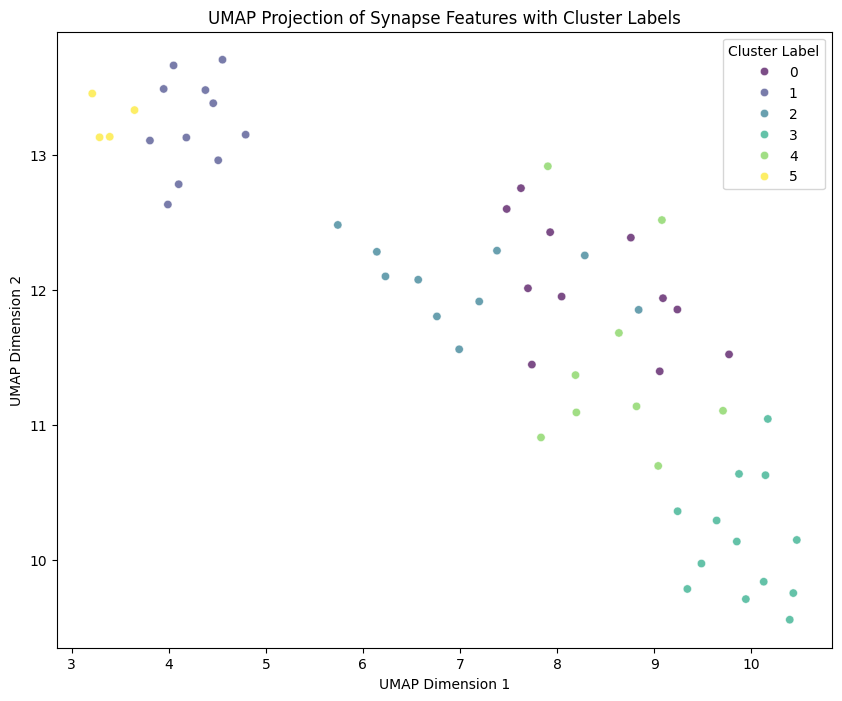

Unique clusters found: [4 5 1 2 0 3]


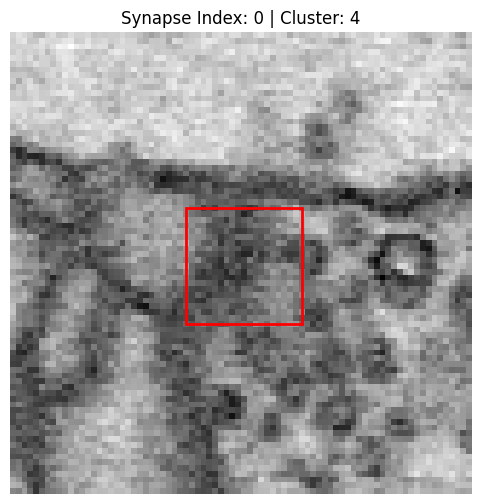

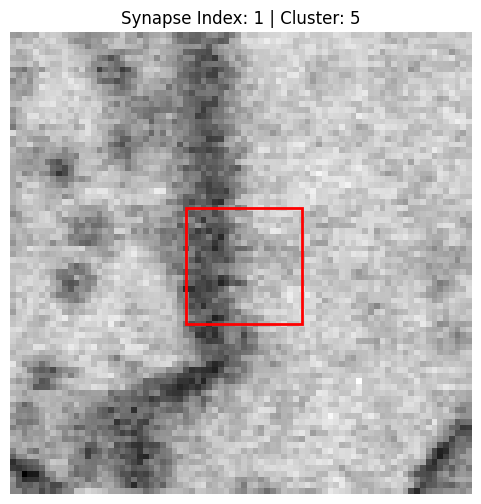

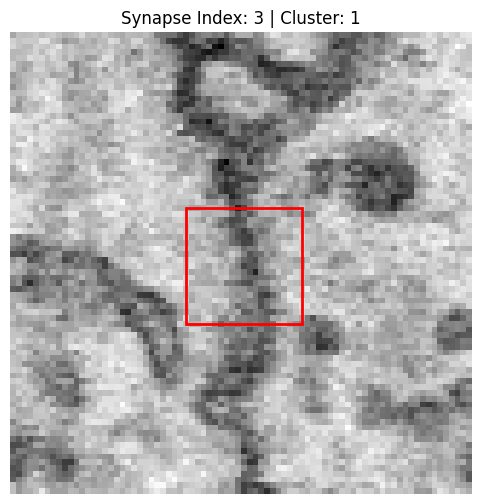

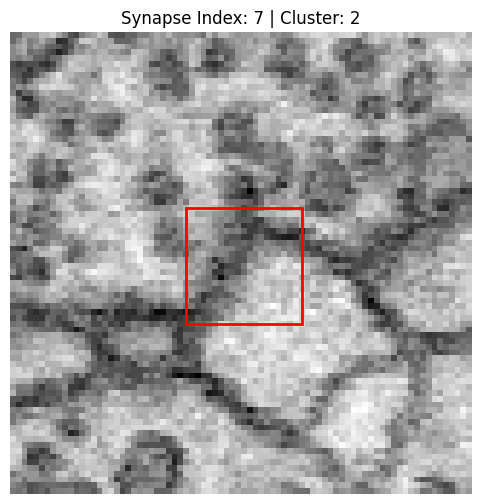

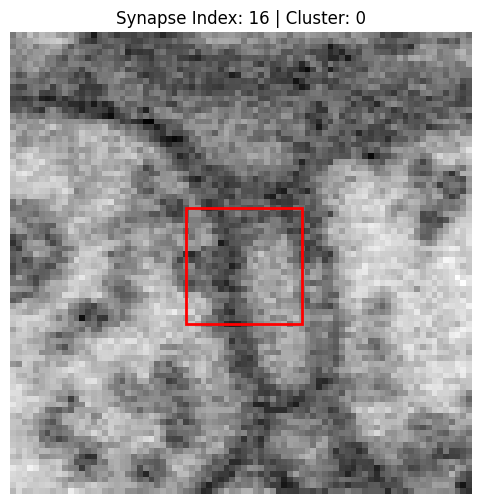

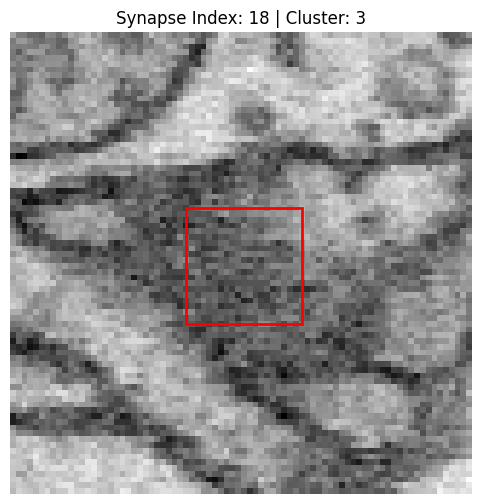

In [7]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
from matplotlib.patches import Rectangle

def plot_elbow_method(features, max_clusters=10):
    inertia = []
    K = range(2, max_clusters+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# plot_elbow_method(all_features_scaled_combined, max_clusters=10)

n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_features_scaled_combined)

df['cluster_label'] = cluster_labels

print(f"Cluster labels assigned to the DataFrame.")

reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(all_features_scaled_combined)

df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP_1', y='UMAP_2',
    hue='cluster_label',
    palette='viridis',
    data=df,
    legend='full',
    alpha=0.7
)
plt.title('UMAP Projection of Synapse Features with Cluster Labels')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster Label')
plt.show()

def visualize_synapse(sample_idx, dataset, df):
    sub_raw, central_slice = dataset[sample_idx]
    central_slice_np = central_slice.squeeze(0).numpy()

    cluster_label = df.iloc[sample_idx]['cluster_label']

    plt.figure(figsize=(6, 6))
    plt.imshow(central_slice_np, cmap='gray')
    plt.title(f"Synapse Index: {sample_idx} | Cluster: {cluster_label}")
    plt.axis('off')

    half_box = 10
    cx, cy = 40, 40
    rect = Rectangle((cx - half_box, cy - half_box), 20, 20, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.show()

unique_clusters = df['cluster_label'].unique()
print(f"Unique clusters found: {unique_clusters}")

for cluster in unique_clusters:
    sample_idx = df[df['cluster_label'] == cluster].index[0]
    visualize_synapse(sample_idx, dataset, df)


# Modify vit to input 3d images

VGG3D checkpoint already exists.


<ipython-input-13-d4ca49b58387>:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


VGG3D model loaded and set to evaluation mode.
Vision Transformer (ViT) model loaded and set to evaluation mode.
VGG3D Feature Extractor initialized.
Loaded DataFrame with 58 synapses.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch 1:
vgg_feats shape: (16, 4096)
vit_feats shape: (16, 768)
scalar_feats shape: (16, 1)
Batch 2:
vgg_feats shape: (16, 4096)
vit_feats shape: (16, 768)
scalar_feats shape: (16, 1)
Batch 3:
vgg_feats shape: (16, 4096)
vit_feats shape: (16, 768)
scalar_feats shape: (16, 1)
Batch 4:
vgg_feats shape: (10, 4096)
vit_feats shape: (10, 768)
scalar_feats shape: (10, 1)
Extracted combined features for 58 synapses.
Combined features standardized.
PCA reduced combined features to 50 dimensions.
Combined feature vectors saved to 'combined_features.npy'.
PCA-reduced combined feature vectors saved to 'combined_features_pca.npy'.
Cluster labels assigned to the DataFrame.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


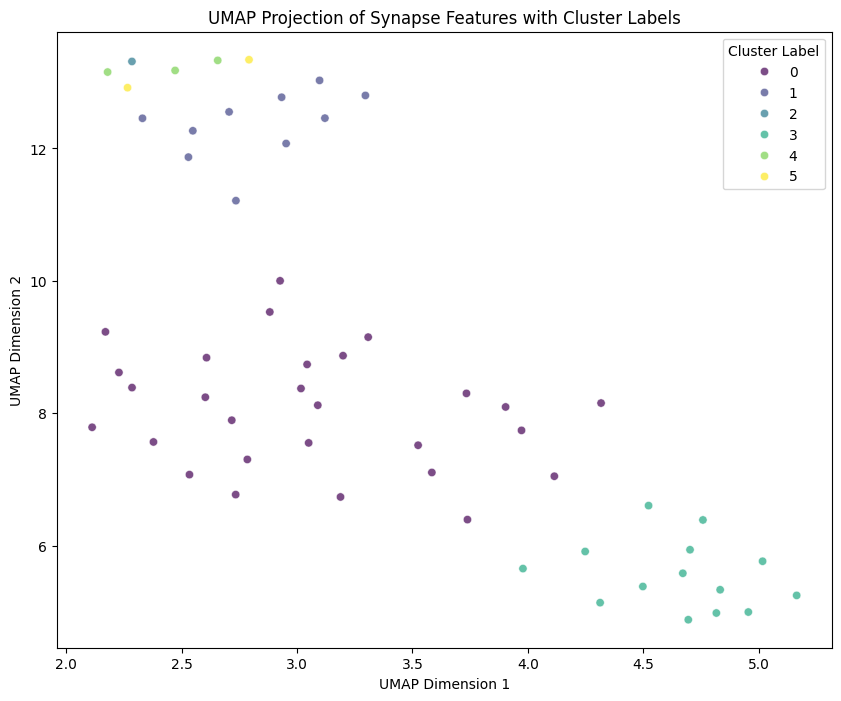

Unique clusters found: [0 2 4 1 5 3]


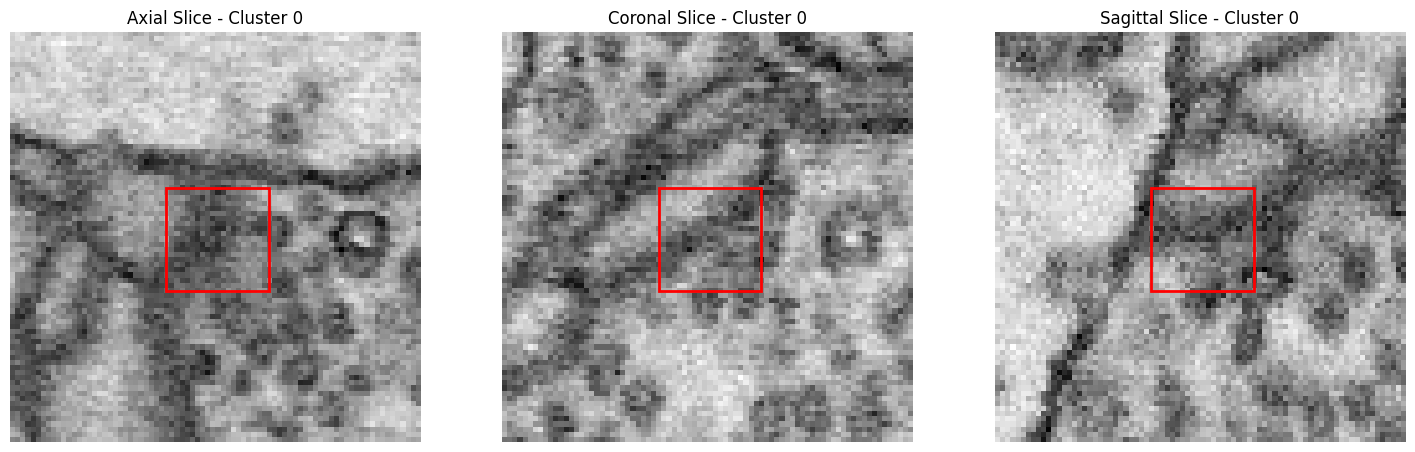

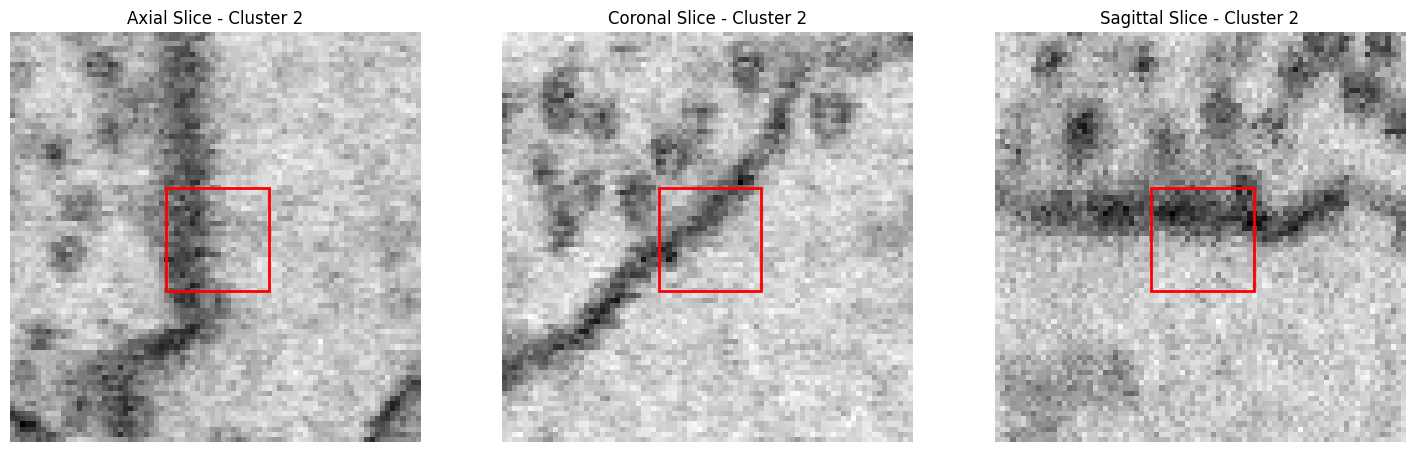

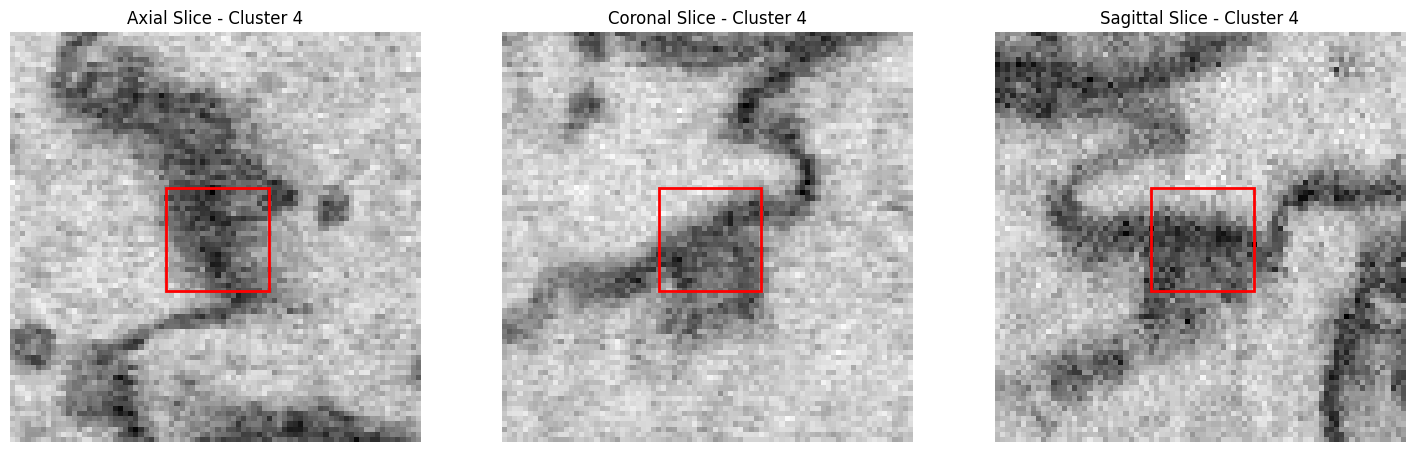

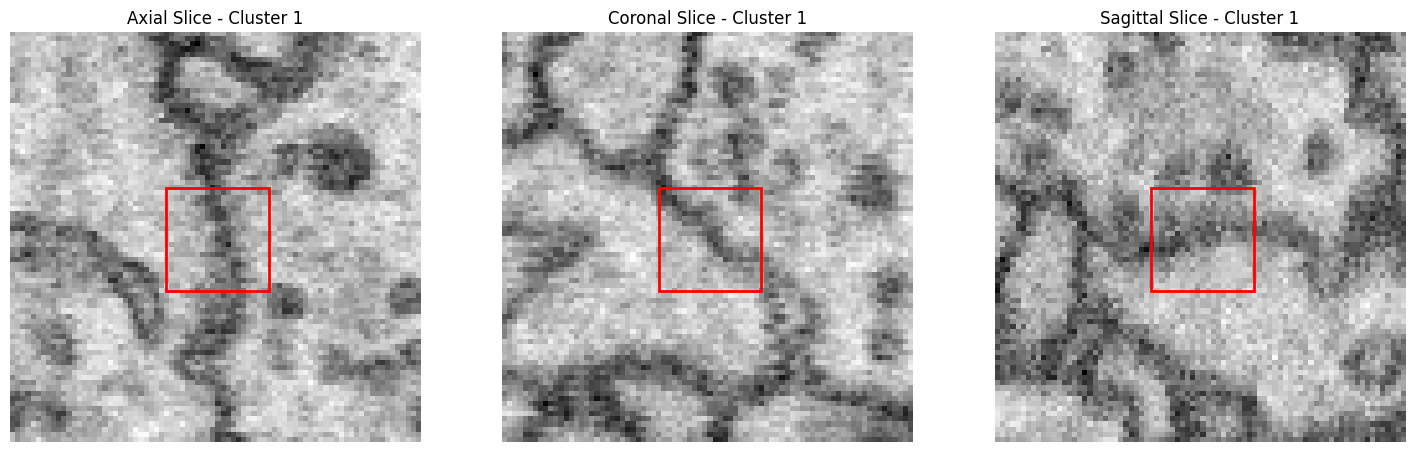

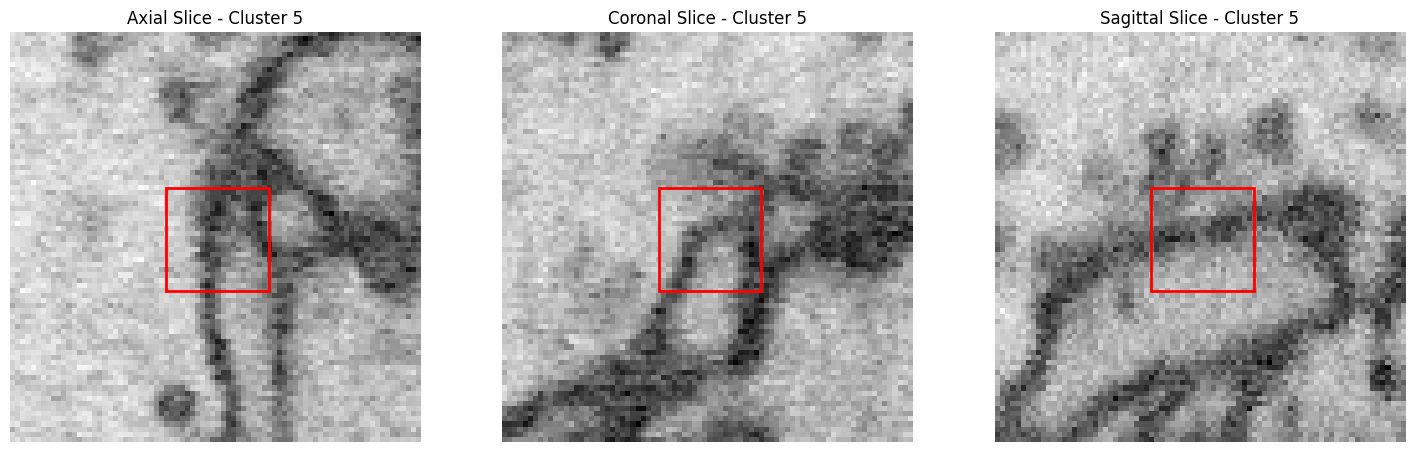

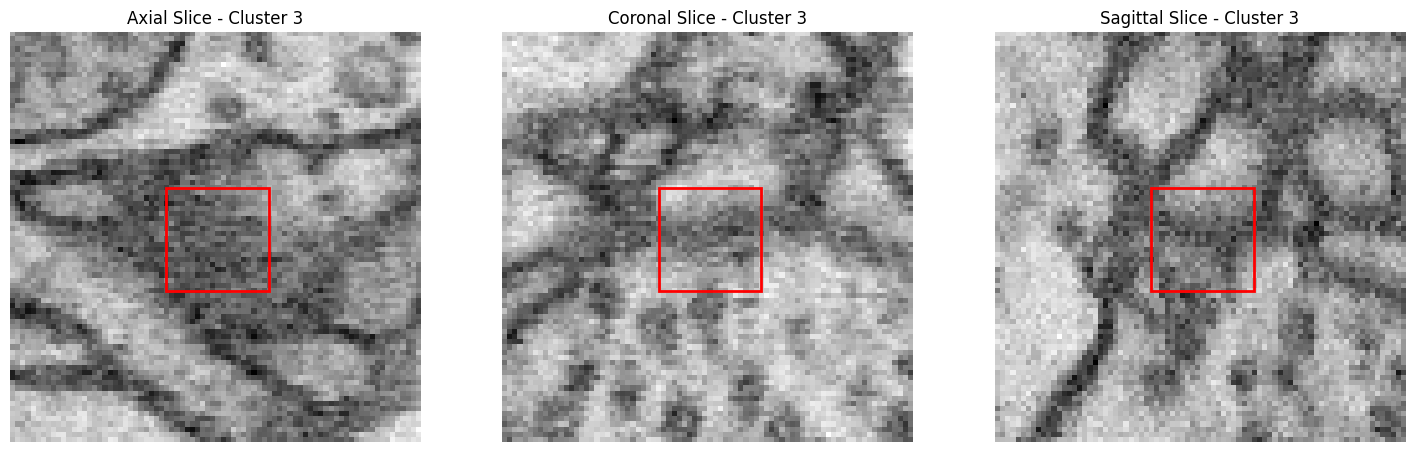

DataFrame with cluster labels saved to 'synapse_with_clusters.xlsx'.


In [13]:


def load_bbox_data(bbox_name, max_slices=None):

    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), "Raw and segmentation file counts do not match."


    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # Shape: (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # Shape: (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):

    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):

    def __init__(self, raw_vol, seg_vol, synapse_df, subvol_size=80):

        self.raw_vol = raw_vol
        self.seg_vol = seg_vol
        self.synapse_df = synapse_df
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(self.seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, self.raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, self.raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, self.raw_vol.shape[0])

        sub_raw = self.raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]


        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_mask_1 = np.zeros(desired_shape, dtype=bool)
        padded_sub_mask_2 = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_mask_1[:dz, :dy, :dx] = sub_mask_1
        padded_sub_mask_2[:dz, :dy, :dx] = sub_mask_2


        # Axial (XY plane)
        axial_slice = padded_sub_raw[self.half_size, :, :]  # Shape: (80, 80)
        # Coronal (XZ plane)
        coronal_slice = padded_sub_raw[:, self.half_size, :]  # Shape: (80, 80)
        # Sagittal (YZ plane)
        sagittal_slice = padded_sub_raw[:, :, self.half_size]  # Shape: (80, 80)


        sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()  # Shape: (1, 80, 80, 80)
        axial_slice_tensor = torch.from_numpy(axial_slice).unsqueeze(0).float()      # Shape: (1, 80, 80)
        coronal_slice_tensor = torch.from_numpy(coronal_slice).unsqueeze(0).float()  # Shape: (1, 80, 80)
        sagittal_slice_tensor = torch.from_numpy(sagittal_slice).unsqueeze(0).float()# Shape: (1, 80, 80)

        return sub_raw_tensor, [axial_slice_tensor, coronal_slice_tensor, sagittal_slice_tensor]


checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'

if not os.path.exists(checkpoint_path):

    print("Downloading VGG3D checkpoint...")

    import requests
    response = requests.get(checkpoint_url, stream=True)
    with open(checkpoint_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")


model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7

)


checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_vgg.load_state_dict(checkpoint['model_state_dict'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vgg.to(device)
model_vgg.eval()
print("VGG3D model loaded and set to evaluation mode.")


model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("Vision Transformer (ViT) model loaded and set to evaluation mode.")


class Vgg3D_FeatureExtractor(torch.nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier

        self.classifier = torch.nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()
print("VGG3D Feature Extractor initialized.")

def get_vit_features(image):


    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=-1)

    pil_image = Image.fromarray(image.astype('uint8'))
    pil_image = pil_image.resize((224, 224))


    inputs = image_processor(images=pil_image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()[0]

    return feats

def get_vit_features_batch(slices):

    pil_images = []
    for img in slices:
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)  # Convert to 3-channel
        pil_img = Image.fromarray(img.astype('uint8'))
        pil_img = pil_img.resize((224, 224))
        pil_images.append(pil_img)


    inputs = image_processor(images=pil_images, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()  # Shape: (B, 768)
    return feats


df = pd.read_excel(excel_file)
print(f"Loaded DataFrame with {len(df)} synapses.")


dataset = SynapseDataset(raw_vol, seg_vol, df, subvol_size=80)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)


all_features_combined = []


for batch_idx, (sub_raw, central_slices) in enumerate(dataloader):

    sub_raw = sub_raw.to(device)

    axial_slices = central_slices[0].to(device)
    coronal_slices = central_slices[1].to(device)
    sagittal_slices = central_slices[2].to(device)


    with torch.no_grad():
        vgg_feats = model_vgg_feat(sub_raw)

        vgg_feats = vgg_feats.cpu().numpy()

    axial_slices_np = [axial_slices[i].squeeze(0).cpu().numpy() for i in range(axial_slices.size(0))]
    coronal_slices_np = [coronal_slices[i].squeeze(0).cpu().numpy() for i in range(coronal_slices.size(0))]
    sagittal_slices_np = [sagittal_slices[i].squeeze(0).cpu().numpy() for i in range(sagittal_slices.size(0))]

    vit_feats_axial = get_vit_features_batch(axial_slices_np)
    vit_feats_coronal = get_vit_features_batch(coronal_slices_np)
    vit_feats_sagittal = get_vit_features_batch(sagittal_slices_np)

    vit_feats = (vit_feats_axial + vit_feats_coronal + vit_feats_sagittal) / 3

    scalar_feats = sub_raw.mean(dim=[2,3,4]).cpu().numpy()

    print(f"Batch {batch_idx + 1}:")
    print(f"vgg_feats shape: {vgg_feats.shape}")
    print(f"vit_feats shape: {vit_feats.shape}")
    print(f"scalar_feats shape: {scalar_feats.shape}")

    combined_features = np.concatenate([vgg_feats, vit_feats, scalar_feats], axis=1)

    all_features_combined.append(combined_features)

    if (batch_idx + 1) % 10 == 0:
        print(f"Processed {batch_idx + 1} batches.")

all_features_combined = np.concatenate(all_features_combined, axis=0)
print(f"Extracted combined features for {all_features_combined.shape[0]} synapses.")


scaler_combined = StandardScaler()
all_features_scaled_combined = scaler_combined.fit_transform(all_features_combined)
print("Combined features standardized.")

pca_combined = PCA(n_components=50, random_state=42)
all_features_pca_combined = pca_combined.fit_transform(all_features_scaled_combined)
print(f"PCA reduced combined features to {all_features_pca_combined.shape[1]} dimensions.")


np.save('combined_features.npy', all_features_combined)
print("Combined feature vectors saved to 'combined_features.npy'.")

np.save('combined_features_pca.npy', all_features_pca_combined)
print("PCA-reduced combined feature vectors saved to 'combined_features_pca.npy'.")



from sklearn.cluster import KMeans

def plot_elbow_method(features, max_clusters=10):
    inertia = []
    K = range(2, max_clusters+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()


n_clusters = 6


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_features_scaled_combined)

df['cluster_label'] = cluster_labels

print("Cluster labels assigned to the DataFrame.")

reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(all_features_scaled_combined)

df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP_1', y='UMAP_2',
    hue='cluster_label',
    palette='viridis',
    data=df,
    legend='full',
    alpha=0.7
)
plt.title('UMAP Projection of Synapse Features with Cluster Labels')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster Label')
plt.show()

def visualize_synapse(sample_idx, dataset, df):

    sub_raw, central_slices = dataset[sample_idx]

    axial_slice = central_slices[0].squeeze(0).numpy()
    coronal_slice = central_slices[1].squeeze(0).numpy()
    sagittal_slice = central_slices[2].squeeze(0).numpy()

    cluster_label = df.iloc[sample_idx]['cluster_label']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(axial_slice, cmap='gray')
    axes[0].set_title(f"Axial Slice - Cluster {cluster_label}")
    axes[0].axis('off')
    rect_axial = Rectangle((40-10, 40-10), 20, 20, linewidth=2, edgecolor='red', facecolor='none')
    axes[0].add_patch(rect_axial)

    axes[1].imshow(coronal_slice, cmap='gray')
    axes[1].set_title(f"Coronal Slice - Cluster {cluster_label}")
    axes[1].axis('off')
    rect_coronal = Rectangle((40-10, 40-10), 20, 20, linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect_coronal)

    axes[2].imshow(sagittal_slice, cmap='gray')
    axes[2].set_title(f"Sagittal Slice - Cluster {cluster_label}")
    axes[2].axis('off')
    rect_sagittal = Rectangle((40-10, 40-10), 20, 20, linewidth=2, edgecolor='red', facecolor='none')
    axes[2].add_patch(rect_sagittal)

    plt.show()

unique_clusters = df['cluster_label'].unique()
print(f"Unique clusters found: {unique_clusters}")

for cluster in unique_clusters:
    sample_idx = df[df['cluster_label'] == cluster].index[0]
    visualize_synapse(sample_idx, dataset, df)


df.to_excel('synapse_with_clusters.xlsx', index=False)
print("DataFrame with cluster labels saved to 'synapse_with_clusters.xlsx'.")
